In [1]:
import glob, os
from pathlib import Path

import pyreadstat
from scipy.stats import entropy
import pandas as pd
from pandas.plotting import parallel_coordinates
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
import geopandas as gpd
import mapclassify
import shapely
import spectra
import matplotlib.patheffects as path_effects
from matplotlib.colors import rgb2hex
import contextily as ctx
from pysal.explore import esda
import libpysal as lps
import pysal as ps
import spreg
from splot.esda import lisa_cluster
from esda.moran import Moran_Local_BV
from esda.moran import Moran_Local
from splot.esda import moran_scatterplot
import matplotlib.colors as mc
from matplotlib.cm import ScalarMappable
import plotly.express as px


%matplotlib inline


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

C:\Users\guill\miniconda3\envs\abm\Lib\site-packages\spaghetti\network.py:41: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(dep_msg, FutureWarning, stacklevel=1)


# 1. Calculate the Neighbourhood balance value for all possible distributions

## 1.1 Load and process housing value in neighbourhoods

In [2]:
range_2019_2020 = ['<250k','250-300k','>300k']

buurt_df = pd.read_excel(r'../data/Housing/price range buurt 2019.xlsx', index_col=0)
buurt_df.fillna(0, inplace=True)
buurt_df.drop('22.       onbekend', axis=1, inplace=True)
buurt_df['<250k'] = buurt_df[buurt_df.columns[0:9]].sum(axis=1)
buurt_df['250-300k'] = buurt_df[buurt_df.columns[10:12]].sum(axis=1)
buurt_df['>300k'] = buurt_df[buurt_df.columns[11:-3]].sum(axis=1)
woon_df = buurt_df[range_2019_2020].copy()
woon_df.index.name = 'BU_NAAM'
woon_df = woon_df.reset_index(level=0)

In [3]:
buurt_df.columns[0:9]

Index(['02.     25.000,-   < 50.000,-', '03.     50.000,-   < 75.000,-',
       '04.     75.000,-  < 100.000,-', '05.    100.000,-  < 125.000,-',
       '06.    125.000,-  < 150.000,-', '07.    150.000,-  < 175.000,-',
       '08.    175.000,-  < 200.000,-', '09.    200.000,-  < 225.000,-',
       '10.    225.000,-  < 250.000,-'],
      dtype='object')

In [4]:
buurt_df[buurt_df.columns[10:12]].sum(axis=1)

Afrikaanderwijk                32.0
Agniesebuurt                   75.0
Bedrijvenpark Noord_West        0.0
Bedrijventerrein Schieveen      0.0
Bergpolder                    147.0
                              ...  
Zestienhoven                   55.0
Zevenkamp                     173.0
Zuiderpark                      7.0
Zuidplein                       0.0
Zuidwijk                      109.0
Length: 93, dtype: float64

In [5]:
buurt_df[buurt_df.columns[11:-3]].sum(axis=1)

Afrikaanderwijk                30.0
Agniesebuurt                   76.0
Bedrijvenpark Noord_West        0.0
Bedrijventerrein Schieveen      0.0
Bergpolder                    116.0
                              ...  
Zestienhoven                  649.0
Zevenkamp                     236.0
Zuiderpark                     34.0
Zuidplein                       3.0
Zuidwijk                       39.0
Length: 93, dtype: float64

In [6]:
# The matching of the neighbourhoods surveyed in the Wijkprofiel and the actual shape of neighbouroods was conducted in a semiautomated way resulting in the Geo_wijkprofiel_match.xlsx file
filename = r'../data/land/Geo_wijkprofiel_match.xlsx'
match_df = pd.read_excel(filename)

In [7]:
match_woon_df = woon_df.merge(match_df, on='BU_NAAM')
match_woon_df.set_index('BU_CODE')

BU_NAAM   <250k  250-300k  >300k   WK_CODE  \
BU_CODE                                                                     
BU05991086             Afrikaanderwijk  3398.0      32.0   30.0  WK059910   
BU05990515                Agniesebuurt  1753.0      75.0   60.0  WK059905   
BU05992459    Bedrijvenpark Noord_West     1.0       0.0    0.0  WK059924   
BU05992650  Bedrijventerrein Schieveen     0.0       0.0    0.0  WK059926   
BU05990531                  Bergpolder  4420.0     147.0  116.0  WK059905   
...                                ...     ...       ...    ...       ...   
BU05990455                Zestienhoven   230.0      55.0  388.0  WK059904   
BU05991466                   Zevenkamp  6470.0     173.0  224.0  WK059914   
BU05991578                  Zuiderpark   314.0       7.0   26.0  WK059915   
BU05991576                   Zuidplein   749.0       0.0    3.0  WK059915   
BU05991573                    Zuidwijk  6165.0     109.0   38.0  WK059915   

            Wijkprofiel index             Wijkprofiel  Match  
BU_CODE                                                       
BU05991086               86.0         Afrikaanderwijk    1.0  
BU05990515               15.0            Agniesebuurt    1.0  
BU05992459                NaN                     NaN    0.0  
BU05992650                NaN                     NaN    0.0  
BU05990531               31.0              Bergpolder    1.0  
...                       ...                     ...    ...  
BU05990455                NaN                     NaN    8.0  
BU05991466               66.0               Zevenkamp    1.0  
BU05991578               78.0  Zuiderpark en Zuidrand    6.0  
BU05991576               76.0               Zuidplein    1.0  
BU05991573               73.0                Zuidwijk    1.0  

[93 rows x 8 columns]

In [8]:
filename = r'..\data\land\shapebuurt2018'
gdf = gpd.read_file(filename)

In [9]:
gdf = gdf.loc[gdf['GM_NAAM'] == 'Rotterdam']
gdf = gdf.to_crs(epsg=28992)

In [10]:
orig_geo_pop = gdf.merge(match_woon_df, on='BU_CODE')
orig_geo_pop = orig_geo_pop.to_crs(epsg=28992)

In [11]:
orig_geo_pop.columns

Index(['BU_CODE', 'BU_NAAM_x', 'WK_CODE_x', 'GM_CODE', 'GM_NAAM', 'geometry',
       'BU_NAAM_y', '<250k', '250-300k', '>300k', 'WK_CODE_y',
       'Wijkprofiel index', 'Wijkprofiel', 'Match'],
      dtype='object')

## 1.2 Calculate the KL divergence

In [12]:
appended_df = []
to_dissolve = range(2,9)
for i in range(2,9):
    #dissolve and create new dataframe with the new geometry for the prices
    orig_geo_pop_to_dissolve_woz = orig_geo_pop.loc[orig_geo_pop['Match'] == i]
    orig_geo_pop_to_dissolve_woz = orig_geo_pop_to_dissolve_woz.drop(columns=['BU_CODE', 'BU_NAAM_x', 'WK_CODE_x', 'GM_CODE', 'GM_NAAM','BU_NAAM_y', 'WK_CODE_y',
                                                         'Wijkprofiel index', 'Wijkprofiel'])
    orig_geo_pop_dissolved_woz = orig_geo_pop_to_dissolve_woz.dissolve(by='Match', aggfunc = 'sum')
    orig_geo_pop_dissolved_woz.reset_index(inplace=True)
    
    #dissolve and create new dataframe with the new geometry for the names
    orig_geo_pop_to_dissolve_name = orig_geo_pop.loc[orig_geo_pop['Match'] == i]
    orig_geo_pop_to_dissolve_name = orig_geo_pop_to_dissolve_name.drop(columns=range_2019_2020)
    orig_geo_pop_dissolved_name = orig_geo_pop_to_dissolve_name.dissolve(by='Match')
    orig_geo_pop_dissolved_name.reset_index(inplace=True)
    
    #merge both
    orig_geo_pop_dissolved_merge = orig_geo_pop_dissolved_woz.merge(orig_geo_pop_dissolved_name)

    #add geometry to list
    appended_df.append(orig_geo_pop_dissolved_merge)
    #delete old geometries from the dataframe
    orig_geo_pop = orig_geo_pop.drop(orig_geo_pop[orig_geo_pop.Match == i].index)
    
appended_df.append(orig_geo_pop)
orig_geo_pop = pd.concat(appended_df)
orig_geo_pop = orig_geo_pop.drop(orig_geo_pop[orig_geo_pop.Match == 0].index)
orig_geo_pop.set_index('Wijkprofiel index', inplace = True)
orig_geo_pop[range_2019_2020] = orig_geo_pop[range_2019_2020].div(orig_geo_pop[range_2019_2020].sum(axis=1), axis=0)

In [13]:
# TO COLLECT ALL OF THEM
all_dfs = []

In [14]:
step = 1
exclude_set = {0}
for m in range(0,40+step,step): 
    if m not in exclude_set:
        for s in range(45-m,60+step,step):
            if s not in exclude_set:

                z=-m-s+100

                if z not in exclude_set:
                    geo_pop = orig_geo_pop.copy()
                    balance_list = []


                    balance_list.append(s)
                    balance_list.append(m)
                    balance_list.append(z)

                    balance = balance_list
                    geo_pop['0' + '_' + str(s) + '_' + str(m) + '_' + str(z)] = geo_pop[range_2019_2020].apply(lambda row : entropy(row, qk=balance), axis = 1)
                    year_KL_df = geo_pop[['0' + '_' + str(s) + '_' + str(m) + '_' + str(z)]]
                    year_KL_df = year_KL_df.mul(-1)
                    all_dfs.append(year_KL_df)
                    #year_KL_df.to_excel(r'..\data\Housing\kl_calculation\0' + '_' + str(s) + '_' + str(m) + '_' + str(z) + '_KL_evolution.xlsx')


In [15]:
step = 1
exclude_set = {0}
for m in range(40+step,45+step,step):
    if m not in exclude_set:
        for s in range(45-m,100-m+step,step):
            if s not in exclude_set:

                z=-m-s+100

                if z not in exclude_set:
                    geo_pop = orig_geo_pop.copy()
                    balance_list = []


                    balance_list.append(s)
                    balance_list.append(m)
                    balance_list.append(z)

                    balance = balance_list
                    geo_pop['1' + '_' + str(s) + '_' + str(m) + '_' + str(z)] = geo_pop[range_2019_2020].apply(lambda row : entropy(row, qk=balance), axis = 1)
                    year_KL_df = geo_pop[['1' + '_' + str(s) + '_' + str(m) + '_' + str(z)]]
                    year_KL_df = year_KL_df.mul(-1)
                    all_dfs.append(year_KL_df)
                    #year_KL_df.to_excel(r'..\data\Housing\kl_calculation\1' + '_' + str(s) + '_' + str(m) + '_' + str(z) + '_KL_evolution.xlsx')


In [16]:
step = 1
exclude_set = {0}
for m in range(45+step,100,step):
    if m not in exclude_set:
        for s in range(0,100-m+step,step):
            if s not in exclude_set:

                z=-m-s+100

                if z not in exclude_set:
                    geo_pop = orig_geo_pop.copy()
                    balance_list = []


                    balance_list.append(s)
                    balance_list.append(m)
                    balance_list.append(z)

                    balance = balance_list
                    geo_pop['2' + '_' + str(s) + '_' + str(m) + '_' + str(z)] = geo_pop[range_2019_2020].apply(lambda row : entropy(row, qk=balance), axis = 1)
                    year_KL_df = geo_pop[['2' + '_' + str(s) + '_' + str(m) + '_' + str(z)]]
                    year_KL_df = year_KL_df.mul(-1)
                    all_dfs.append(year_KL_df)
                    #year_KL_df.to_excel(r'..\data\Housing\kl_calculation\2' + '_' + str(s) + '_' + str(m) + '_' + str(z) + '_KL_evolution.xlsx')


# 2. Merge Neighbourhood balance with the data from the Wijkprofiel

In [17]:
# Load data downloded from the Wijkprofiel. Only selected columns
sc_dir = r'../data/Wijkprofiel/Wijkprofiel_2020_vars.xlsx'
sc_df = pd.read_excel(sc_dir, index_col=0, sheet_name='Selected')

## 2.1 Address Groot_ijsselmonde
The neighborhood of Groot IJsselmonde was divided into North and South. Since the housing data is collected according to official administrative boundaries, the Wijkprofiel values for Groot IJsselmonde North and South needed to be aggregated. This was done by calculating a weighted average, using the number of Wijkprofiel respondents in each area as the weighting factor.

In [18]:
# neighbourhood codes
groot_ijseelmonde = [1009, 1010]

#number of respondents in each neighbourhood according to the survey data
respondents_north = 287
respondents_south = 260

In [19]:
gi_agg_df  = sc_df[sc_df.index.isin(groot_ijseelmonde)]

In [20]:
gi_agg_df.drop(['buurt'], axis=1, inplace=True)
gi_agg_df_T = gi_agg_df.T

In [21]:
#calculates weighted average
def avg_perc(col1,col2,pop1,pop2):
    return (col1*pop1+col2*pop2)/(pop1+pop2)

gi_combined_df = gi_agg_df_T.apply(lambda x: avg_perc(x[1009], x[1010],respondents_north,respondents_south), axis=1)

In [22]:
gi_combined_df = gi_combined_df.to_frame()
gi_combined_df = gi_combined_df.rename(columns={0: 1009})
gi_combined_df = gi_combined_df.T

In [23]:
gi_combined_df['buurt'] = 'Groot Ijsselmonde'

In [24]:
# Now that we have the row for groot ijsselmonde combined, 
# with the wijkprofiel index that corresponds to north just for later merging, we delete the north and south in the original
sc_df=sc_df.drop(1009)
sc_df=sc_df.drop(1010)

In [25]:
# and we concat the average
sc_df = pd.concat([sc_df,gi_combined_df])

In [26]:
sc_df.index.names = ['Wijkprofiel index']

## 2.2 Now we can go back to merging the KL divergence with the Wijkprofiel data
Note that in the code we use the nomenclature from the Wijkprofiel such that:
SC1 = 'aggv20a', 
SC2 = 'aggv20b',
SC3 = 'aggv20d',
SC4 = 'aggv20f',
SC5 = 'aggv20h',
IS1 = 'v46b'

In [27]:
step = 1
exclude_set = {0}
for m in range(0,40+step,step): 
    if m not in exclude_set:
        for s in range(45-m,60+step,step):
            if s not in exclude_set:

                z=-m-s+100

                if z not in exclude_set:
                    kl_dir = r'..\data\Housing\kl_calculation\0' + '_' + str(s) + '_' + str(m) + '_' + str(z) + '_KL_evolution.xlsx'
                    kl_df = pd.read_excel(kl_dir, index_col=0)
                    kl_sc_df = kl_df.merge(sc_df, on = 'Wijkprofiel index')
                    kl_sc_df.columns = ['KL_2019', 'buurt',
                    'aggv20a', 'aggv20b','aggv20d','aggv20f','aggv20h','aggv46b']
                    #kl_sc_df.to_excel(r'..\data\processed\0' + '_' + str(s) + '_' + str(m) + '_' + str(z) + '_kl_sc_2019.xlsx')

In [28]:
step = 1
exclude_set = {0}
for m in range(40+step,45+step,step):
    if m not in exclude_set:
        for s in range(45-m,100-m+step,step):
            if s not in exclude_set:

                z=-m-s+100

                if z not in exclude_set:
                    kl_dir = r'..\data\Housing\kl_calculation\1' + '_' + str(s) + '_' + str(m) + '_' + str(z) + '_KL_evolution.xlsx'
                    kl_df = pd.read_excel(kl_dir, index_col=0)
                    kl_sc_df = kl_df.merge(sc_df, on = 'Wijkprofiel index')
                    kl_sc_df.columns = ['KL_2019', 'buurt',
                    'aggv20a', 'aggv20b','aggv20d','aggv20f','aggv20h','aggv46b']
                    #kl_sc_df.to_excel(r'..\data\processed\1' + '_' + str(s) + '_' + str(m) + '_' + str(z) + '_kl_sc_2019.xlsx')

In [29]:
step = 1
exclude_set = {0}
for m in range(45+step,100,step):
    if m not in exclude_set:
        for s in range(0,100-m+step,step):
            if s not in exclude_set:

                z=-m-s+100

                if z not in exclude_set:
                    kl_dir = r'..\data\Housing\kl_calculation\2' + '_' + str(s) + '_' + str(m) + '_' + str(z) + '_KL_evolution.xlsx'
                    kl_df = pd.read_excel(kl_dir, index_col=0)
                    kl_sc_df = kl_df.merge(sc_df, on = 'Wijkprofiel index')
                    kl_sc_df.columns = ['KL_2019', 'buurt',
                    'aggv20a', 'aggv20b','aggv20d','aggv20f','aggv20h','aggv46b']
                    #kl_sc_df.to_excel(r'..\data\processed\2' + '_' + str(s) + '_' + str(m) + '_' + str(z) + '_kl_sc_2019.xlsx')

# 3. Use PLS-SEM for the estimations
Proceed to the estimations using R in the file code\r_code.R

# 4. Find the solutions that fit the model

## 4.1 First we plot the whole solution space

In [30]:
m_list = []
s_list = []
z_list = []

# Solutions to the inequalities
step = 1
for m in range(0,40+step,step):
    for s in range(45-m,60+step,step):
        z=-m-s+100
        m_list.append(m)
        s_list.append(s)
        z_list.append(z)
        
for m in range(40+step,45+step,step):
    for s in range(45-m,100-m+step,step):
        z=-m-s+100
        m_list.append(m)
        s_list.append(s)
        z_list.append(z)

for m in range(45+step,100,step):
    for s in range(0,100-m+step,step):
        z=-m-s+100
        m_list.append(m)
        s_list.append(s)
        z_list.append(z)

        
df = pd.DataFrame({'Social': s_list, 'Middle': m_list, 'Higher+Top': z_list})
# Add a source column to differentiate
df['label'] = 'All'

In [31]:
# Create a ListedColormap with the last 4 colors from the "Set3" colormap
cmap = matplotlib.colors.ListedColormap(matplotlib.cm.get_cmap("Set3").colors[:])

# Extract RGB values for the first three colors
color_1 = matplotlib.colors.to_hex(cmap(4))  # Convert RGB to hex
color_2 = matplotlib.colors.to_hex(cmap(1))  # Convert RGB to hex

# Define a better color map
color_map = {
    'All': color_1, 
    'Fit': color_2,  
}

# Create the ternary scatter plot with custom sizes
fig = px.scatter_ternary(
    df, 
    a="Social", 
    b="Middle", 
    c="Higher+Top", 
    color="label",
    color_discrete_map=color_map,
    size_max=100                 # Adjust max size as needed
)


# Update layout for the ternary plot with specified intervals and max values
fig.update_layout({
    'ternary': {
        'sum': 100,  # Set the sum to 100 for proper normalization
        'aaxis': {
            'title': '', 
            'min': 0, 
            'linewidth': 2, 
            'ticks': 'outside',
            'tickmode': 'array',
            'tickvals': [0, 20, 40, 60, 80, 100],
            'color': 'black' 
        },
        'baxis': {
            'title': '', 
            'min': 0, 
            'linewidth': 2, 
            'ticks': 'outside',
            'tickmode': 'array',
            'tickvals': [0, 20, 40, 60, 80, 100],
            'color': 'black' 
        },
        'caxis': {
            'title': '', 
            'min': 0, 
            'linewidth': 2, 
            'ticks': 'outside',
            'tickmode': 'array',
            'tickvals': [0, 20, 40, 60, 80, 100],
            'color': 'black' 
        }
    },
    'showlegend': False,
    'font': {
        'family': 'Verdana',  
        'size': 12            
    }
})

# Remove contour for Dataset 1
fig.update_traces(
    marker=dict(
        line=dict(width=0)  
    ),
    selector=dict(name='All')  # Apply this only to points from df ALL
)

fig.show()

## 4.2 Identify and plot the distributions that fit the model

In [32]:
column_names = ["sweep", "Social", "Middle", "Higher+Top", "suffix"]

In [33]:
dir_est = r'..\estimations'
os.chdir(dir_est)
to_concat = []
for file in glob.glob("*_estimates.xlsx"):
    name_list = [file.split('_')]
    name_index0 = name_list[0][:-1]
    name_index = '_'.join(name_index0)

    name_df = pd.DataFrame(name_list, columns=column_names)
    name_df.rename(index={0:name_index},inplace=True)

    to_concat.append(name_df)
    
df_fit = pd.concat(to_concat)

In [34]:
df_bl = df_fit[['Social', 'Middle', 'Higher+Top']]
df_bl.head()

Social Middle Higher+Top
0_48_1_51     48      1         51
0_50_1_49     50      1         49
0_52_1_47     52      1         47
0_53_40_7     53     40          7
0_54_1_45     54      1         45

In [35]:
# Add a source column to differentiate
df_bl['label'] = 'Fit'

# Combine the DataFrames
combined_df = pd.concat([df, df_bl], ignore_index=True)

In [36]:
# Back to directory
dir_est = r'..\code'
os.chdir(dir_est)

In [37]:
# Create a ListedColormap with the last 4 colors from the "Set3" colormap
cmap = matplotlib.colors.ListedColormap(matplotlib.cm.get_cmap("Set3").colors[:])

# Extract RGB values for the first three colors
color_1 = matplotlib.colors.to_hex(cmap(4))  # Convert RGB to hex
color_2 = matplotlib.colors.to_hex(cmap(5))  # Convert RGB to hex

# Define a better color map
color_map = {
    'All': color_1, 
    'Fit': color_2,  
}
# Create a new column 'point_size' to control the size of the points
combined_df['point_size'] = combined_df['label'].apply(lambda x: 2 if x == 'Fit' else 10)

# Create the ternary scatter plot with custom sizes
fig = px.scatter_ternary(
    combined_df, 
    a="Social", 
    b="Middle", 
    c="Higher+Top", 
    color="label",
    color_discrete_map=color_map,
    symbol="label",            # Use different symbols for points based on the label
    symbol_sequence=["circle", "circle"],  # Specify different markers
    size="point_size",          # Use the custom size column
    size_max=10                 # Adjust max size as needed
)


# Update layout for the ternary plot with specified intervals and max values
fig.update_layout({
    'ternary': {
        'sum': 100,  # Set the sum to 100 for proper normalization
        'aaxis': {
            'title': '', 
            'min': 0, 
            'linewidth': 2, 
            'ticks': 'outside',
            'tickmode': 'array',
            'tickvals': [0, 20, 40, 60, 80, 100],
            'color': 'black' 
        },
        'baxis': {
            'title': '', 
            'min': 0, 
            'linewidth': 2, 
            'ticks': 'outside',
            'tickmode': 'array',
            'tickvals': [0, 20, 40, 60, 80, 100],
            'color': 'black' 
        },
        'caxis': {
            'title': '', 
            'min': 0, 
            'linewidth': 2, 
            'ticks': 'outside',
            'tickmode': 'array',
            'tickvals': [0, 20, 40, 60, 80, 100],
            'color': 'black' 
        }
    },
    'showlegend': False,
    'font': {
        'family': 'Verdana',  
        'size': 12            
    }
})

# Remove contour for Dataset 1
fig.update_traces(
    marker=dict(
        line=dict(width=0)  
    ),
    selector=dict(name='All')  # Apply this only to points from df ALL
)

fig.show()

## 4.3 Cluster the distributions

### 4.3.1 Elbow method

In [38]:
df_cl = df_fit[['sweep', 'Social', 'Middle', 'Higher+Top']]
df_cl = df_cl.apply(pd.to_numeric)
df_cl['index'] = np.arange(len(df_fit))

In [39]:
X = df_cl.iloc[:,2:]

In [40]:
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}

# A list holds the SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)

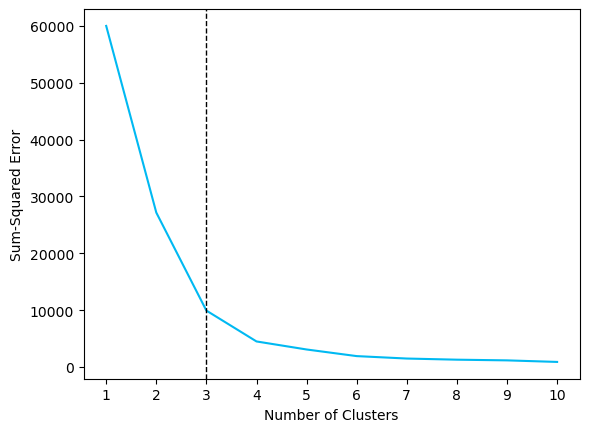

In [41]:
plt.plot(range(1, 11), sse, c='#00b9f2')
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Sum-Squared Error")
plt.axvline(x=3, c='black',lw=1,ls='--')

In [42]:
from kneed import KneeLocator
kl = KneeLocator(
    range(1, 11), sse, curve="convex", direction="decreasing"
)

kl.elbow

3

### 4.3.2 Silhoutte method

In [43]:
from sklearn.metrics import silhouette_score

# A list holds the silhouette coefficients for each k
silhouette_coefficients = []

# Notice you start at 2 clusters for silhouette coefficient
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(X)
    score = silhouette_score(X, kmeans.labels_)
    silhouette_coefficients.append(score)

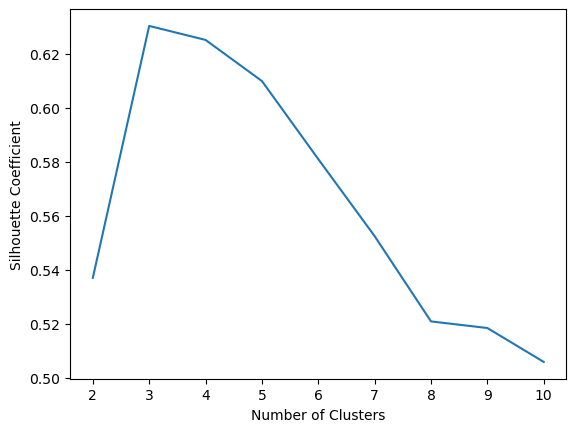

In [44]:
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

### 4.3.3 Apply the k-means algorithm with k=3

In [45]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)
df_cl.loc[:,'kmeans'] = kmeans.labels_

In [46]:
df_cl_plot = df_cl[['Social','Middle', 'Higher+Top', 'kmeans']]
df_cl_plot.rename(columns={'kmeans':'label'}, inplace=True)

In [47]:
# Combine the DataFrames
cluster_combined_df = pd.concat([df, df_cl_plot], ignore_index=True)

In [48]:
cluster_combined_df.iloc[-1]

Social        52
Middle        46
Higher+Top     2
label          0
Name: 3360, dtype: object

In [49]:
# Back to directory
dir_est = r'..\code'
os.chdir(dir_est)

In [50]:
# Create a ListedColormap with colors from the "Set3" colormap
cmap = matplotlib.colors.ListedColormap(matplotlib.cm.get_cmap("Set3").colors[:])

# Extract RGB values for the first three colors
color_1 = matplotlib.colors.to_hex(cmap(4))  # Convert RGB to hex
color_2 = matplotlib.colors.to_hex(cmap(5))  # Convert RGB to hex
color_3 = matplotlib.colors.to_hex(cmap(8))  # Convert RGB to hex
color_4 = matplotlib.colors.to_hex(cmap(9))  # Convert RGB to hex
color_5 = matplotlib.colors.to_hex(cmap(10))  # Convert RGB to hex


# Define a better color map
color_map = {
    'All': color_1, 
    'Fit': color_2,
    0 : color_3,
    1 : color_4,
    2 : color_5
}

# Create a new column 'point_size' to control the size of the points
cluster_combined_df['point_size'] = cluster_combined_df['label'].apply(lambda x: 10 if x == 'All' else 2)

# Create the ternary scatter plot with custom sizes
fig = px.scatter_ternary(
    cluster_combined_df, 
    a="Social", 
    b="Middle", 
    c="Higher+Top", 
    color="label",
    color_discrete_map=color_map,
    symbol="label",            # Use different symbols for points based on the label
    symbol_sequence=["square", "circle", "cross", "diamond"],  # Specify different markers
    size="point_size",          # Use the custom size column
    size_max=10                 # Adjust max size as needed
)


# Update layout for the ternary plot with specified intervals and max values
fig.update_layout({
    'ternary': {
        'sum': 100,  # Set the sum to 100 for proper normalization
        'aaxis': {
            'title': '', 
            'min': 0, 
            'linewidth': 2, 
            'ticks': 'outside',
            'tickmode': 'array',
            'tickvals': [0, 20, 40, 60, 80, 100],
            'ticktext': ['0%', '20%', '40%', '60%', '80%', '100%'],  # Add percentage signs to ticks
            'color': 'black' 
        },
        'baxis': {
            'title': '', 
            'min': 0, 
            'linewidth': 2, 
            'ticks': 'outside',
            'tickmode': 'array',
            'tickvals': [0, 20, 40, 60, 80, 100],
            'ticktext': ['0%', '20%', '40%', '60%', '80%', '100%'],  # Add percentage signs to ticks
            'color': 'black' 
        },
        'caxis': {
            'title': '', 
            'min': 0, 
            'linewidth': 2, 
            'ticks': 'outside',
            'tickmode': 'array',
            'tickvals': [0, 20, 40, 60, 80, 100],
            'ticktext': ['0%', '20%', '40%', '60%', '80%', '100%'],  # Add percentage signs to ticks
            'color': 'black' 
        }
    },
    'font': {
        'family': 'Verdana',  
        'size': 12            
    }
})

# Reduce the alpha (opacity) of the symbols
fig.update_traces(
    marker=dict(
        opacity=1  # Set the opacity to 0.6 (adjust this value as needed)
    )
)
# Remove contour for Dataset 1
fig.update_traces(
    marker=dict(
        line=dict(width=0)  
    ),
    selector=dict(name='All')  # Apply this only to points from df ALL
)
# Apply contour color only to specific labels
for cluster_label in ['0', '1', '2']:
    fig.update_traces(
        marker=dict(
            line=dict(
                width=0.1,  # Set the line width for the contour
                color='black'  # Set the color for the contour (change as needed)
            )
        ),
        selector=dict(name=cluster_label)  # Apply this only to specified cluster labels
    )


# Add annotations for axes
# fig.add_annotation(
#     text='Social',
#     x=0, y=0.5, 
#     showarrow=False,
#     font=dict(size=12, family='Verdana'),
#     xref='paper', yref='paper'
# )

# fig.add_annotation(
#     text='Middle',
#     x=0.5, y=0, 
#     showarrow=False,
#     font=dict(size=12, family='Verdana'),
#     xref='paper', yref='paper'
# )

# fig.add_annotation(
#     text='Higher+Top',
#     x=1, y=0.5,  
#     showarrow=False,
#     font=dict(size=12, family='Verdana'),
#     xref='paper', yref='paper'
# )

fig.show()

# 5. Identification of the models with the best goodness-of-fit

## 5.1 Values for NB, SC, IS for sweeps

In [51]:
dir_est = r'..\estimations'
os.chdir(dir_est)
to_concat = []
for file in glob.glob("*_estimates.xlsx"):
    name_list = file.split('_')[:-1]
    name_index = '_'.join(name_list)
    sweep = name_list[0]
    
    path_df = pd.read_excel(dir_est + '\\' + file)
    path_df = path_df.T
    path_df.columns = path_df.iloc[0]
    path_df = path_df.drop(path_df.index[0])
    path_df = path_df.loc['Estimate'].to_frame().T
    path_df.rename(index={'Estimate':name_index},inplace=True)
    path_df['sweep'] = sweep
    
    to_concat.append(path_df)

df_paths = pd.concat(to_concat)

In [52]:
df_paths.head()

Name        SC ~ BN   IS ~ BN   IS ~ SC sweep
0_48_1_51  0.516151  0.132907  0.268321     0
0_50_1_49  0.483435  0.111971  0.282791     0
0_52_1_47  0.444891  0.090553  0.296635     0
0_53_40_7 -0.204873  0.224254  0.355327     0
0_54_1_45  0.400075  0.069006  0.309314     0

In [53]:
df_paths['index'] = np.arange(len(df_paths))
df_paths = df_paths.apply(pd.to_numeric)

In [54]:
df_paths.rename(columns = {'SC ~ BN':'SC ~ NB', 'IS ~ BN':'IS ~ NB', 'IS ~ SC':'IS ~ SC'}, inplace = True)

## 5.2 Values for NB, SC, IS for clusters

In [55]:
dir_est = r'..\estimations'
os.chdir(dir_est)
to_concat = []
for file in glob.glob("*_estimates.xlsx"):
    name_list = file.split('_')[:-1]
    name_index = '_'.join(name_list)
    sweep = name_list[0]
    
    p_df = pd.read_excel(dir_est + '\\' + file)
    p_df = p_df.T
    p_df.columns = p_df.iloc[0]
    p_df = p_df.drop(p_df.index[0])
    p_df = p_df.loc['p_value'].to_frame().T
    p_df.rename(index={'p_value':name_index},inplace=True)

    
    to_concat.append(p_df)

df_p = pd.concat(to_concat)
df_p.rename(columns = {'SC ~ BN':'SC ~ NB', 'IS ~ BN':'IS ~ NB', 'IS ~ SC':'IS ~ SC'}, inplace = True)

In [56]:
df_p = df_p<=0.05 # significance

In [57]:
df_paths_c = df_paths[['SC ~ NB','IS ~ NB','IS ~ SC']]
df_paths_c = df_paths_c.mask(~df_p)
df_paths_c = pd.merge(df_paths_c, df_cl, left_index=True, right_index=True)
df_paths_c = df_paths_c[['SC ~ NB','IS ~ NB','IS ~ SC','kmeans']]

## 5.3 Select model with best fit (lowest SRMR)

In [58]:
dir_est = r'..\estimations'
os.chdir(dir_est)
to_concat = []
for file in glob.glob("*_quality.xlsx"):
    name_list = file.split('_')[:-1]
    name_index = '_'.join(name_list)
    sweep = name_list[0]
    
    srmr_df = pd.read_excel(dir_est + '\\' + file, sheet_name = 'Distance and Fit measures')
    srmr_df = srmr_df.T
    srmr_df = srmr_df.loc['SRMR'].to_frame()
    srmr_df.rename(index={0:name_index},inplace=True)
    srmr_df['sweep'] = sweep
    
    to_concat.append(srmr_df)

df_srmrs = pd.concat(to_concat)

In [59]:
#Model with best fit
df_best_fit = df_paths_c.loc[df_srmrs['SRMR'].idxmin()].to_frame().T
df_best_fit_selection = pd.concat([df_srmrs, df_paths_c], axis=1)

In [60]:
df_1 = df_cl.loc[df_best_fit_selection[df_best_fit_selection['kmeans'] == 0]['SRMR'].idxmin()].to_frame().T
df_2 = df_cl.loc[df_best_fit_selection[df_best_fit_selection['kmeans'] == 1]['SRMR'].idxmin()].to_frame().T
df_3 = df_cl.loc[df_best_fit_selection[df_best_fit_selection['kmeans'] == 2]['SRMR'].idxmin()].to_frame().T

final_df = pd.concat([df_1,df_2,df_3])

final_df = final_df[['Social','Middle','Higher+Top','kmeans']]
final_df = final_df.rename(columns={'kmeans':'Cluster'})

remap = {0: 'Cluster 1', 1: 'Cluster 2', 2: 'Cluster 3'}
final_df.replace({"Cluster": remap}, inplace=True)

# Using DataFrame.insert() to add a column
final_df.insert(4, "Model", ['Model 1', 'Model 2', 'Model 3'], True)
final_df

Social  Middle  Higher+Top    Cluster    Model
2_28_71_1      28      71           1  Cluster 1  Model 1
1_54_42_4      54      42           4  Cluster 2  Model 2
0_57_1_42      57       1          42  Cluster 3  Model 3

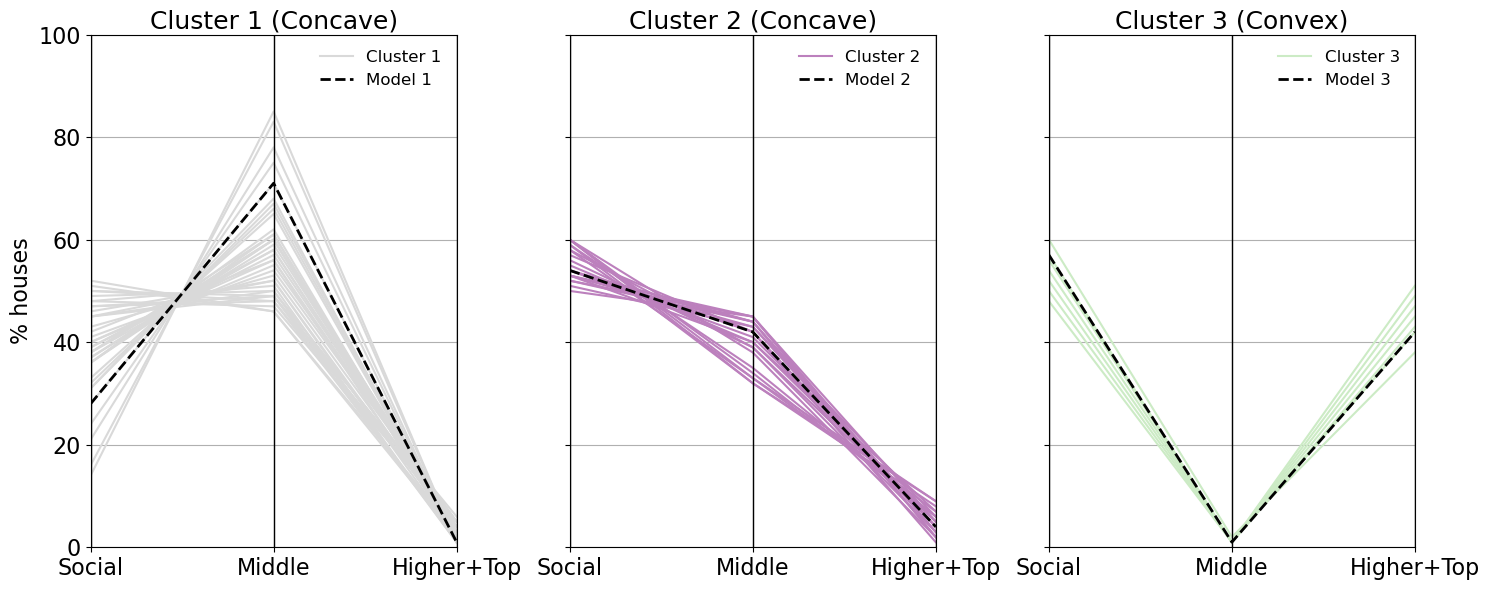

In [61]:
# Replace kmeans values with descriptive names
df_cl['kmeans'] = df_cl['kmeans'].map({0: 'Cluster 1', 1: 'Cluster 2', 2: 'Cluster 3'})

# Create subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(15, 6))

# Define colormap
cmap = matplotlib.colors.ListedColormap(matplotlib.cm.get_cmap("Set3").colors[-4:])

# Plot parallel coordinates for each cluster with updated labels
parallel_coordinates(df_cl[df_cl['kmeans'] == 'Cluster 1'][['Social', 'Middle', 'Higher+Top', 'kmeans']], 'kmeans', color=cmap(0), ax=ax1)
parallel_coordinates(df_cl[df_cl['kmeans'] == 'Cluster 2'][['Social', 'Middle', 'Higher+Top', 'kmeans']], 'kmeans', color=cmap(1), ax=ax2)
parallel_coordinates(df_cl[df_cl['kmeans'] == 'Cluster 3'][['Social', 'Middle', 'Higher+Top', 'kmeans']], 'kmeans', color=cmap(2), ax=ax3)

# Remove the default legends from parallel_coordinates
for ax in [ax1, ax2, ax3]:
    ax.get_legend().remove()


# Plot best model lines and add individual legends
for ax, cluster in zip([ax1, ax2, ax3], ['Cluster 1', 'Cluster 2', 'Cluster 3']):
    best_row = final_df[final_df['Cluster'] == cluster].iloc[0]
    ax.plot(['Social', 'Middle', 'Higher + Top'], 
            [best_row['Social'], best_row['Middle'], best_row['Higher+Top']], 
            color='black', linestyle='--', linewidth=2, 
            label=best_row['Model'])
    
    # Add a legend for the current subplot only
    ax.legend(title_fontsize='13', fontsize='12', loc='upper right', frameon=False)

# Set axis limits
ax1.set_ylim([0, 100])
ax2.set_ylim([0, 100])
ax3.set_ylim([0, 100])

# Set labels and ticks
ax1.set_ylabel('% houses', fontsize=16)
ax1.tick_params(axis="y", labelsize=16)
ax1.tick_params(axis="x", labelsize=16)
ax1.set_xlabel('Cluster 1 (Concave)', fontsize=18)
ax1.xaxis.set_label_position('top') 

ax2.tick_params(axis="x", labelsize=16)
ax2.set_xlabel('Cluster 2 (Concave)', fontsize=18)
ax2.xaxis.set_label_position('top') 

ax3.tick_params(axis="x", labelsize=16)
ax3.set_xlabel('Cluster 3 (Convex)', fontsize=18)
ax3.xaxis.set_label_position('top') 

fig.tight_layout()

plt.show()

# 6. Spatial analysis

In [62]:
filename = r'..\data\land\outcome_Geo_wijkprofiel_match.shp'
gdf = gpd.read_file(filename)
gdf.rename(columns = {'Wijkprofie':'Wijkprofiel_index'}, inplace = True)
gdf = gdf.loc[gdf['GM_NAAM'] == 'Rotterdam']
gdf = gdf.to_crs(epsg=28992)

In [63]:
# For the analysis, the values calculated in PLS-SEM were manually added to create the *maps_input.xlsx files
dir_est = r'..\estimations\selected_models'
os.chdir(dir_est)

cols_to_keep = ['Wijkprofiel_index', 'BN', 'SC', 'IS']

cluster_1 = '2_28_71_1_'
df_cluster_1 = pd.read_excel(cluster_1+ 'maps_input.xlsx')
df_cluster_1.rename(columns = {'Wijkprofiel index':'Wijkprofiel_index'}, inplace = True)
df_cluster_1 = df_cluster_1[cols_to_keep]
df_cluster_1.set_index('Wijkprofiel_index', inplace=True)
geo_pop_1 = gdf.join(df_cluster_1, on='Wijkprofiel_index')
geo_pop_1['Model'] = 1


cluster_2 = '1_54_42_4_'
df_cluster_2 = pd.read_excel(cluster_2+ 'maps_input.xlsx')
df_cluster_2.rename(columns = {'Wijkprofiel index':'Wijkprofiel_index'}, inplace = True)
df_cluster_2 = df_cluster_2[cols_to_keep]
df_cluster_2.set_index('Wijkprofiel_index', inplace=True)
geo_pop_2 = gdf.join(df_cluster_2, on='Wijkprofiel_index')
geo_pop_2['Model'] = 2


cluster_3 = '0_57_1_42_'
df_cluster_3 = pd.read_excel(cluster_3+ 'maps_input.xlsx')
df_cluster_3.rename(columns = {'Wijkprofiel index':'Wijkprofiel_index'}, inplace = True)
df_cluster_3 = df_cluster_3[cols_to_keep]
df_cluster_3.set_index('Wijkprofiel_index', inplace=True)
geo_pop_3 = gdf.join(df_cluster_3, on='Wijkprofiel_index')
geo_pop_3['Model'] = 3


geo_pop = pd.concat([geo_pop_1,geo_pop_2,geo_pop_3]) 

## 6.1 Bivariate map

In [64]:
# Prepare map bivariate colors and legend
n_categories = 3
full_palette = sns.diverging_palette(220, 20,n=(n_categories - 1) * 2 + 1)
full_palette[2] = (0.88,0.88,0.88)
cmap_x = full_palette[n_categories - 1:]
cmap_y = list(reversed(full_palette))[n_categories - 1:]

cmap_xy = []
bivariate_palette = {}

for j in range(n_categories):
    for i in range(n_categories):
        x = spectra.rgb(*cmap_x[i][0:3])
        y = spectra.rgb(*cmap_y[j][0:3])
        
        if i == j and i == 0:
            cmap_xy.append(x.darken(1.5).rgb)
        elif i == 0:
            cmap_xy.append(y.rgb)
        elif j == 0:
            cmap_xy.append(x.rgb)
        else: 
            blended = x.blend(y, ratio=0.5)
            
            if i == j:
                blended = blended.saturate(3.5*(i + 1))
            else:
                blended = blended.saturate(4.5*(i + 1))
                
            cmap_xy.append(blended.rgb)
            
        bivariate_palette[(i, j)] = rgb2hex(cmap_xy[-1])
            
cmap_xy = np.array(cmap_xy).reshape(n_categories, n_categories, 3)

In [65]:
#Doesnt matter which geo_pop use, all geometrires are equal
bounds = geo_pop_1.total_bounds
aspect = (bounds[2] - bounds[0]) / (bounds[3] - bounds[1])
box = shapely.geometry.box(*bounds)

In [66]:
dir_est = r'..'
os.chdir(dir_est)
filename = r'..\data\land\shapewijk2018\Wijken_2018.shp'
gdf_wijk = gpd.read_file(filename)

gdf_wijk = gdf_wijk.loc[gdf_wijk['GM_NAAM'] == 'Rotterdam']
gdf_wijk = gdf_wijk.to_crs(epsg=28992)

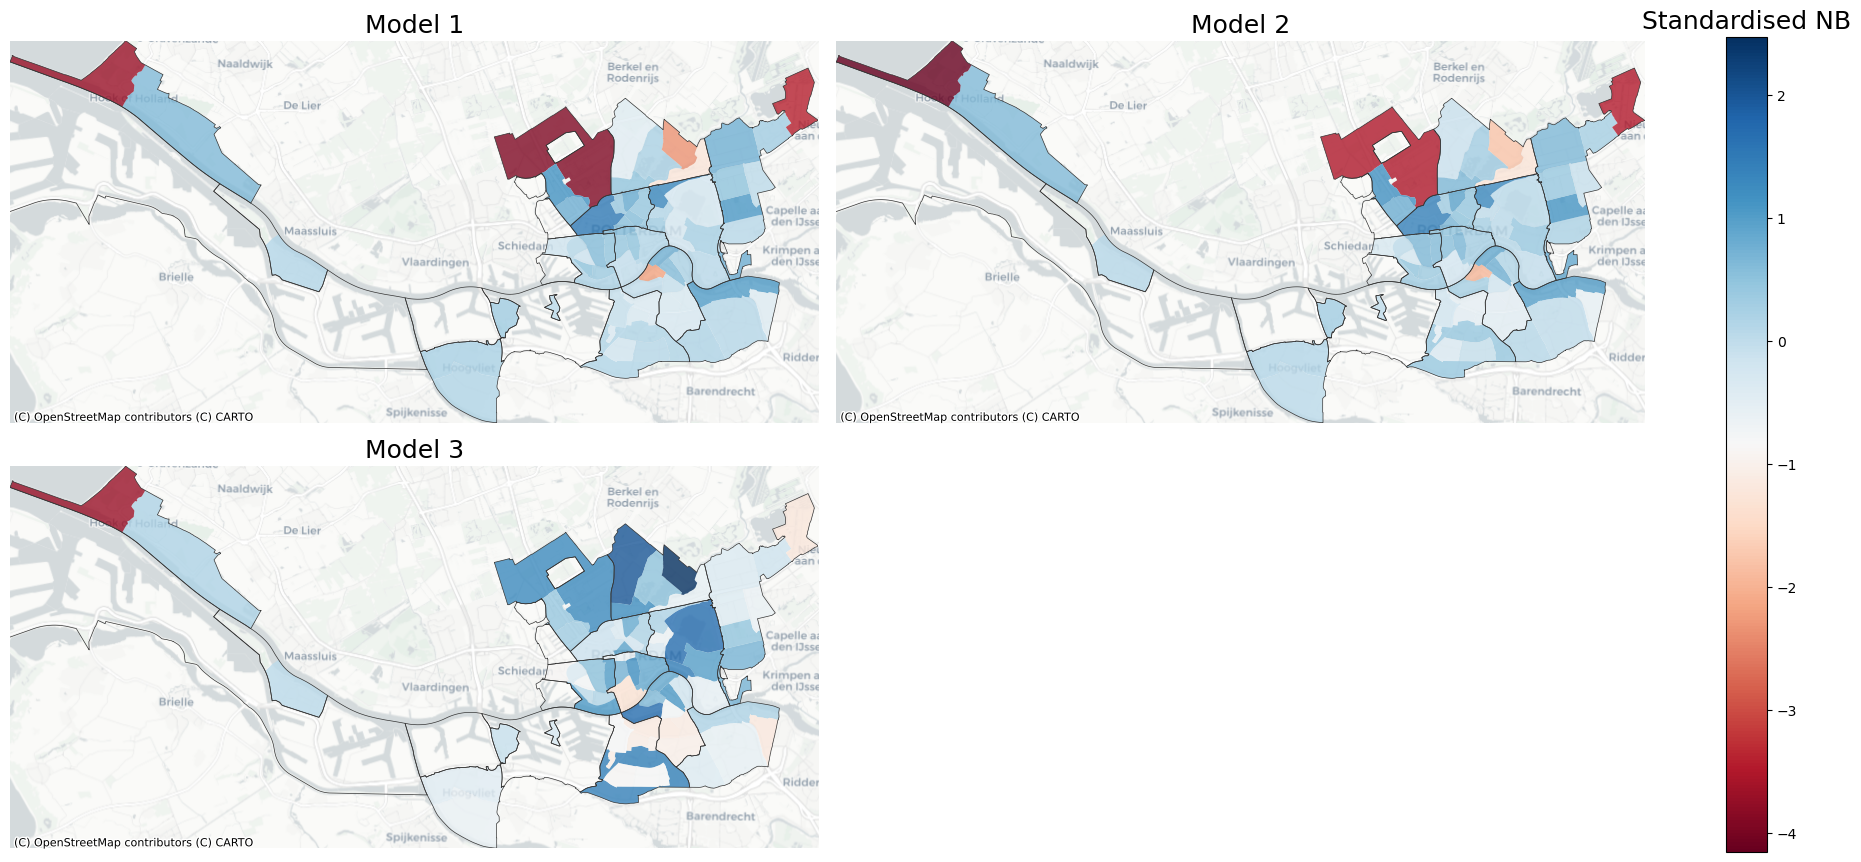

In [67]:
to_plot = 'BN'

fig, axes = plt.subplots(2, 2, figsize=(18, 18 / aspect),constrained_layout=True, 
                        # sharex=True, sharey=True, 
                        subplot_kw=dict(aspect='equal'))


norm = matplotlib.colors.Normalize(vmin=geo_pop[to_plot].min(), vmax=geo_pop[to_plot].max())


for ax, c in zip(axes.reshape(-1),np.unique(geo_pop.Model.values)):
    ax.set_xlim(bounds[0], bounds[2])
    ax.set_ylim(bounds[1], bounds[3])
    
    ax.set_title('Model '+ str(c))
    ax.title.set_size(18)
    geo_pop[geo_pop.Model == c].plot(to_plot, ax=ax, norm=norm, cmap='RdBu', alpha=0.8, edgecolor='none')
    gdf_wijk.plot(facecolor='none', edgecolor='#333333', linewidth=0.5, ax=ax)
    ctx.add_basemap(crs='EPSG:28992', source=ctx.providers.CartoDB.Positron, ax=ax) # add the basemap
    ax.set_axis_off()

    
axes[1,1].axis('off')

#For latter colorbar
axes_bar = axes.ravel()
sm = plt.cm.ScalarMappable(cmap='RdBu', norm=norm)
sm._A = []
cbar = fig.colorbar(sm, ax=axes_bar)
cbar.ax.set_title('Standardised NB', fontsize=18)  

plt.show()

## 6.2 LISA map

In [68]:
geo_analysis = geo_pop.copy()

In [69]:
# Calculate weights
for c in np.unique(geo_analysis.Model.values):
    print(c)
    if c == 1:
        wq =  lps.weights.Queen.from_dataframe(geo_analysis[geo_analysis['Model']==c])
        wq.transform = 'r'
        islands = wq.islands
        geo_analysis.drop(geo_analysis.index[islands], inplace=True)
        wq =  lps.weights.Queen.from_dataframe(geo_analysis[geo_analysis['Model']==c])
        wq.transform = 'r'

        mi = esda.Moran(geo_analysis[geo_analysis['Model']==c]['SC'], wq)
        print('SC', mi.I)
        print('SC', mi.p_sim)
        miBN = esda.Moran(geo_analysis[geo_analysis['Model']==c]['BN'], wq)
        print('BN', miBN.I)
        print('BN', miBN.p_sim)
        miIS = esda.Moran(geo_analysis[geo_analysis['Model']==c]['IS'], wq)
        print('IS', miIS.I)
        print('IS', miIS.p_sim)
    else:
        wq =  lps.weights.Queen.from_dataframe(geo_analysis[geo_analysis['Model']==c])
        wq.transform = 'r'
        islands = wq.islands
        geo_analysis.drop(geo_analysis.index[islands], inplace=True)
        wq =  lps.weights.Queen.from_dataframe(geo_analysis[geo_analysis['Model']==c])
        wq.transform = 'r'

        mi = esda.Moran(geo_analysis[geo_analysis['Model']==c]['SC'], wq)
        print('SC', mi.I)
        print('SC', mi.p_sim)
        miBN = esda.Moran(geo_analysis[geo_analysis['Model']==c]['BN'], wq)
        print('BN', miBN.I)
        print('BN', miBN.p_sim)
        miIS = esda.Moran(geo_analysis[geo_analysis['Model']==c]['IS'], wq)
        print('IS', miIS.I)
        print('IS', miIS.p_sim)

1
('WARNING: ', 49, ' is an island (no neighbors)')
('WARNING: ', 65, ' is an island (no neighbors)')
('WARNING: ', 69, ' is an island (no neighbors)')
SC 0.2981761627689108
SC 0.001
BN -0.09767969216819954
BN 0.121
IS 0.181131867536528
IS 0.013
2
SC 0.2981761627689108
SC 0.003
BN -0.11026475325596202
BN 0.101
IS 0.181131867536528
IS 0.018
3
SC 0.3543708094675249
SC 0.001
BN 0.07386400408891607
BN 0.148
IS 0.181131867536528
IS 0.021


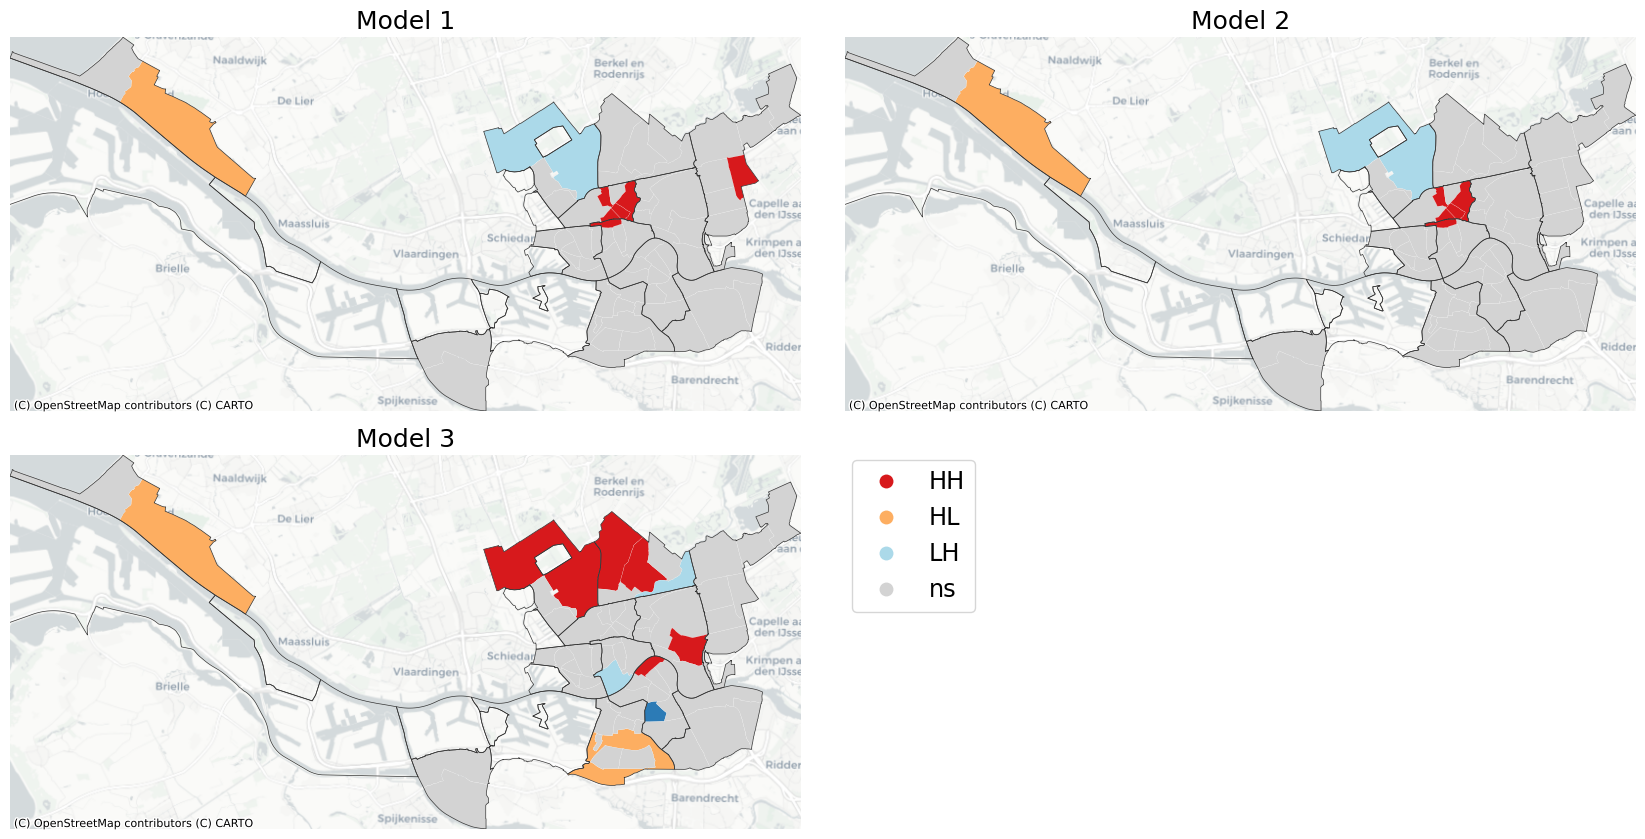

In [70]:
to_plot = 'BN'

fig, axes = plt.subplots(2, 2, figsize=(17, 18/aspect),constrained_layout=True, 
                        # sharex=True, sharey=True, 
                        subplot_kw=dict(aspect='equal'))
fig.tight_layout()
for ax, c in zip(axes.reshape(-1),np.unique(geo_analysis.Model.values)):
    if c == 1:
        wq =  lps.weights.Queen.from_dataframe(geo_analysis[geo_analysis['Model']==c])
        wq.transform = 'r'
        islands = wq.islands
        geo_analysis.drop(geo_analysis.index[islands], inplace=True)
        wq =  lps.weights.Queen.from_dataframe(geo_analysis[geo_analysis['Model']==c])
        wq.transform = 'r'

        y = geo_analysis[geo_analysis['Model']==c][to_plot].values

        moran_loc = Moran_Local(y, wq)

        ax.set_xlim(bounds[0], bounds[2])
        ax.set_ylim(bounds[1], bounds[3])

        ax.set_title('Model '+ str(c))
        ax.title.set_size(18)
        lisa_cluster(moran_loc, geo_analysis[geo_analysis.Model == c], p=0.05, figsize = (9,9), ax=ax, 
                     legend_kwds={'loc': 'upper left', 'bbox_to_anchor': (1.05, -0.1), 'fontsize' : 'xx-large'})
        gdf_wijk.plot(facecolor='none', edgecolor='#333333', linewidth=0.5, ax=ax)
        ctx.add_basemap(crs='EPSG:28992', source=ctx.providers.CartoDB.Positron, ax=ax) # add the basemap
    else:
        wq =  lps.weights.Queen.from_dataframe(geo_analysis[geo_analysis['Model']==c])
        wq.transform = 'r'
        islands = wq.islands
        geo_analysis.drop(geo_analysis.index[islands], inplace=True)
        wq =  lps.weights.Queen.from_dataframe(geo_analysis[geo_analysis['Model']==c])
        wq.transform = 'r'

        y = geo_analysis[geo_analysis['Model']==c][to_plot].values

        moran_loc = Moran_Local(y, wq)

        ax.set_xlim(bounds[0], bounds[2])
        ax.set_ylim(bounds[1], bounds[3])

        ax.set_title('Model '+ str(c))
        ax.title.set_size(18)
        lisa_cluster(moran_loc, geo_analysis[geo_analysis.Model == c], p=0.05, figsize = (9,9), ax=ax,legend=False)
        gdf_wijk.plot(facecolor='none', edgecolor='#333333', linewidth=0.5, ax=ax)
        ctx.add_basemap(crs='EPSG:28992', source=ctx.providers.CartoDB.Positron, ax=ax) # add the basemap

axes[1,1].axis('off')
                
fig.subplots_adjust(wspace=0)
plt.show()